# Iterative Workflows and Provenance Chains

Iterative equilibrium workflows show up all over scientific computing: transportation, economics,
agent-based simulation, MCMC, and more. The pattern is simple: outputs from one step become inputs
to the next until the system converges.

This tutorial focuses on Consist mechanics, not transportation modeling. You can treat the model
functions as black boxes and still learn the key patterns.

**Prerequisites:** Quickstart and the Usage Guide.

## What you'll learn

- How Consist tracks deep, multi-step iteration chains
- How incremental runs skip work you already computed
- How to query lineage to understand impact and reproducibility

## The model in 30 seconds

People choose how to travel, car trips create congestion, and congestion feeds back into the next
round of choices. We run 10 iterations and watch the system stabilize.


## Setup

We initialize the tracker and load the model functions. The details of the model live in
`examples/src/travel_demand_functions.py`, but we treat them as implementation details here.


In [1]:
from __future__ import annotations

import sys
from pathlib import Path


def _find_repo_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / "pyproject.toml").exists():
            return candidate
    raise RuntimeError("Could not locate repo root (missing pyproject.toml)")


REPO_ROOT = _find_repo_root(Path.cwd())
EXAMPLES_DIR = REPO_ROOT / "examples"
EXAMPLES_SRC = EXAMPLES_DIR / "src"

for path in (REPO_ROOT, EXAMPLES_SRC):
    if str(path) not in sys.path:
        sys.path.insert(0, str(path))

In [2]:
from dataclasses import asdict, replace

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from rich.progress import track

import consist
from consist import Tracker, define_step

from travel_demand_functions import (
    AssignmentParams,
    DestinationChoiceParams,
    ModeChoiceParams,
    TravelDemandScenarioConfig,
    ZoneParams,
    apply_congestion,
    apply_mode_choice,
    compute_mode_shares,
    compute_mode_utilities,
    compute_od_logsums,
    compute_od_volumes,
    create_skims_dataset,
    distribute_trips,
    generate_distances,
    generate_population,
    generate_zones,
    save_skims,
    summarize_iteration,
)

sns.set_theme(style="whitegrid")

In [3]:
RUN_DIR = EXAMPLES_DIR / "runs" / "travel_demand_demo"
SESSION_ID = os.getenv("CONSIST_SESSION_ID", "demo")
DB_PATH = RUN_DIR / f"travel_demand_demo_{SESSION_ID}.duckdb"
if DB_PATH.exists():
    DB_PATH.unlink()

%config InlineBackend.figure_format = 'svg'

tracker = Tracker(
    run_dir=RUN_DIR,
    db_path=DB_PATH,
    hashing_strategy="fast",
    project_root=str(RUN_DIR),
)

## Model Configuration

We set up a small, fixed configuration for a 5-zone linear city. The parameters aren't important
for understanding Consist—what matters is that the model is iterative and produces artifacts each step.


In [4]:
zone_params = ZoneParams()
mode_params = ModeChoiceParams()
dest_params = DestinationChoiceParams()
assignment_params = AssignmentParams()

DEFAULT_SEED = 0

base_config = TravelDemandScenarioConfig(
    n_iterations=10,
    seed=DEFAULT_SEED,
    zone_params=zone_params,
    mode_params=mode_params,
    dest_params=dest_params,
    assignment_params=assignment_params,
)

SCENARIO_NAME = "travel_demand_demo"

SKIM_PERTURBATION = 0.1
DESTINATION_UPDATE_SHARE = 0.2

## Workflow Structure (Iteration Loop)

The loop below is the conceptual anchor. Each iteration consumes the previous iteration's
`skims` (travel times), produces new trips, assigns congestion, and updates `skims` again.

```
┌─────────────┐
│    init     │ (iteration 0 only)
└──────┬──────┘
       │ skims, zones, population
       ▼
┌─────────────┐
│   logsums   │◄─── skims, zones
└──────┬──────┘
       │ logsums
       ▼
┌─────────────┐
│ trip_dist   │◄─── logsums, zones, population
└──────┬──────┘
       │ trips
       ▼
┌─────────────┐
│ utilities   │◄─── trips, skims, zones
└──────┬──────┘
       │ utilities
       ▼
┌─────────────┐
│ mode_choice │◄─── utilities, (prev trips_with_modes)
└──────┬──────┘
       │ trips_with_modes
       ▼
┌─────────────┐
│ assignment  │◄─── trips_with_modes
└──────┬──────┘
       │ volumes
       ▼
┌─────────────┐
│ traffic_sim │◄─── volumes, skims
└──────┬──────┘
       │ updated skims ──► next iteration
       ▼
```

For a quick explanation of `run(...)` vs `trace(...)`, see the
[Usage Guide](../docs/usage-guide.md#when-does-code-execute-understanding-scrun-vs-sctrace).


### Simplified run loop (shape only)

Below is a compact outline of the iterative loop. The full implementation (with logging and plotting) follows.

```python
def run_scenario(scenario_config, scenario_run_id):
    with consist.scenario(scenario_run_id, config=..., tags=[...]) as scenario:
        scenario.run(name="init", fn=initialize_scenario, ...)
        for i in range(scenario_config.n_iterations):
            with scenario.trace(name="logsums", ...):
                ...
            scenario.run(name="trip_distribution", ...)
            scenario.run(name="calculate_utilities", ...)
            scenario.run(name="mode_choice", ...)
            scenario.run(name="assignment", ...)
            scenario.run(name="traffic_simulation", ...)
        scenario.run(name="summaries", ...)
    return results
```


### Notebook comparison note

This notebook demonstrates both `scenario.run(...)` and `scenario.trace(...)` to show the differences between the two execution patterns. 
The transportation demand notebook (03) sticks to `scenario.run(...)` only, uses options objects for data-bearing steps, and shows explicit RunResult chaining with `consist.ref(...)` for clearer dataflow contracts.


## Workflow Functions (black box)

The cell below contains the full workflow definition. It's long, but you don't need to read it
line-by-line to follow the Consist concepts. The main takeaway is that each step logs artifacts
and the next step links them explicitly with `consist.ref(previous_result, key=...)`.


In [5]:
from consist import CacheOptions, ExecutionOptions


@define_step(outputs=["skims", "persons", "zones"])
def initialize_scenario(*, zone_params, mode_params, skim_perturbation, _consist_ctx):
    zones = generate_zones(zone_params)
    population = generate_population(zones)
    distances = generate_distances(zone_params)

    skims = create_skims_dataset(zones, distances, mode_params)
    skims["time_car_mins"] *= skim_perturbation

    input_skims_path = _consist_ctx.output_path("skims_init", ext="zarr")

    save_skims(skims, input_skims_path)

    _consist_ctx.log_output(input_skims_path, key="skims")
    consist.log_dataframe(
        population,
        key="persons",
        direction="output",
    )
    consist.log_dataframe(zones, key="zones", direction="output")


@define_step(outputs=["trips"])
def distribute_trips_step(
    *, zones, persons, logsums, dest_params, seed, update_share, trips=None
):
    population = persons
    prev_trips = trips
    logsums_df = logsums
    if "origin" not in logsums_df.columns or "destination" not in logsums_df.columns:
        logsums_df = logsums_df.reset_index()
    logsums_da = logsums_df.set_index(["origin", "destination"])["logsum"].to_xarray()
    trips_df = distribute_trips(
        population,
        zones,
        logsums_da,
        dest_params,
        seed=seed,
        prev_trips=prev_trips,
        update_share=update_share,
    )
    consist.log_dataframe(trips_df, key="trips")


@define_step(
    outputs=[
        "mode_shares",
        "iteration_summaries",
        "pmt_totals",
    ]
)
def summarize_results_step(*, mode_shares, summaries, pmt_totals, _consist_ctx):
    mode_shares_df = (
        pd.DataFrame.from_dict(mode_shares, orient="index")
        .sort_index()
        .rename_axis("iteration")
        .reset_index()
    )
    summaries_df = (
        pd.DataFrame.from_dict(summaries, orient="index")
        .sort_values("iteration")
        .reset_index(drop=True)
    )
    pmt_totals_df = (
        pd.DataFrame.from_dict(pmt_totals, orient="index")
        .sort_index()
        .rename_axis("iteration")
        .reset_index()
    )

    mode_shares_path = _consist_ctx.output_path("summary/mode_shares", ext="csv")
    summaries_path = _consist_ctx.output_path("summary/iteration_summaries", ext="csv")
    pmt_totals_path = _consist_ctx.output_path("summary/pmt_totals", ext="csv")

    consist.log_dataframe(
        mode_shares_df,
        key="mode_shares",
        path=mode_shares_path,
    )
    consist.log_dataframe(
        summaries_df,
        key="iteration_summaries",
        path=summaries_path,
    )
    consist.log_dataframe(
        pmt_totals_df,
        key="pmt_totals",
        path=pmt_totals_path,
    )


def run_scenario(scenario_config, scenario_run_id):
    mode_shares = {}
    summaries = {}
    pmt_totals = {}

    zone_params = scenario_config.zone_params
    mode_params = scenario_config.mode_params
    dest_params = scenario_config.dest_params
    assignment_params = scenario_config.assignment_params
    seed = scenario_config.seed

    with consist.scenario(
        scenario_run_id,
        tracker=tracker,
        config={
            **asdict(scenario_config),
            "scenario_name": SCENARIO_NAME,
        },
        facet_from=["n_iterations"],
        tags=["examples", "simulation", "travel_demand"],
    ) as scenario:
        cache_validation = "lazy"  # Skip output checks on cache hits for speed; use 'eager' to validate files.
        cache_hydration = (
            "inputs-missing"  # Copy cached inputs into the new run_dir on cache misses.
        )

        init_result = scenario.run(
            name="init",
            fn=initialize_scenario,
            config=asdict(mode_params)
            | asdict(zone_params)
            | {"skim_perturbation": SKIM_PERTURBATION},
            facet_from=["skim_perturbation"],
            execution_options=ExecutionOptions(
                inject_context=True,
                runtime_kwargs={
                    "zone_params": zone_params,
                    "mode_params": mode_params,
                    "skim_perturbation": SKIM_PERTURBATION,
                },
            ),
        )

        zones_ref = consist.ref(init_result, key="zones")
        persons_ref = consist.ref(init_result, key="persons")
        skims_result = init_result
        previous_trip_distribution_result = None
        latest_mode_choice_result = None

        for i in track(
            range(scenario_config.n_iterations), description="Running iterations..."
        ):
            # Inline trace pattern (no wrapper function required).
            with scenario.trace(
                name="logsums",
                run_id=f"{scenario.run_id}_logsums_{i}",
                config=asdict(mode_params),
                inputs={
                    "skims": consist.ref(skims_result, key="skims"),
                    "zones": zones_ref,
                },
                facet_from=[
                    "beta_cost",
                    "beta_time",
                    "asc_walk",
                    "asc_transit",
                    "fuel_cost_per_mile",
                    "transit_fare",
                ],
                validate_cached_outputs=cache_validation,
                cache_hydration=cache_hydration,
                iteration=i,
            ) as t:
                if not t.is_cached:
                    skims = t.load(consist.ref(skims_result, key="skims"))
                    zones = consist.load_df(zones_ref, tracker=tracker)
                    logsums = compute_od_logsums(
                        skims,
                        zones,
                        mode_params,
                    )
                    consist.log_dataframe(
                        logsums.to_dataframe().reset_index(),
                        key="logsums",
                    )

            logsums_artifact = scenario.coupler.require("logsums")
            trip_inputs = {
                "zones": zones_ref,
                "persons": persons_ref,
                "logsums": logsums_artifact,
            }
            if previous_trip_distribution_result is not None:
                trip_inputs["trips"] = consist.ref(
                    previous_trip_distribution_result, key="trips"
                )

            trip_distribution_result = scenario.run(
                name="trip_distribution",
                fn=distribute_trips_step,
                run_id=f"{scenario.run_id}_trip_distribution_{i}",
                config={
                    **asdict(dest_params),
                    "update_share": DESTINATION_UPDATE_SHARE,
                },
                inputs=trip_inputs,
                facet_from=["beta_size", "beta_access", "update_share"],
                execution_options=ExecutionOptions(
                    load_inputs=True,
                    runtime_kwargs={
                        "dest_params": dest_params,
                        "seed": seed + i,
                        "update_share": DESTINATION_UPDATE_SHARE,
                    },
                ),
                iteration=i,
            )

            # ExecutionOptions with input auto-loading hydrates artifacts into function args by name.
            utilities_result = scenario.run(
                name="calculate_utilities",
                fn=compute_mode_utilities,
                run_id=f"{scenario.run_id}_utilities_{i}",
                config=asdict(mode_params),
                inputs={
                    "trips": consist.ref(trip_distribution_result, key="trips"),
                    "skims": consist.ref(skims_result, key="skims"),
                    "zones": zones_ref,
                },
                facet_from=[
                    "beta_cost",
                    "beta_time",
                    "asc_walk",
                    "asc_transit",
                ],
                cache_options=CacheOptions(
                    validate_cached_outputs=cache_validation,
                    cache_hydration=cache_hydration,
                ),
                execution_options=ExecutionOptions(
                    load_inputs=True,
                    runtime_kwargs={"mode_params": mode_params},
                ),
                outputs=["utilities"],
                iteration=i,
            )

            mode_choice_result = scenario.run(
                name="mode_choice",
                fn=apply_mode_choice,
                run_id=f"{scenario.run_id}_mode_choice_{i}",
                config={"seed": seed},
                inputs={
                    "utilities_df": consist.ref(utilities_result, key="utilities")
                },
                execution_options=ExecutionOptions(
                    load_inputs=True,
                    runtime_kwargs={"seed": seed + i},
                ),
                outputs=["trips_with_modes"],
                iteration=i,
            )

            assignment_result = scenario.run(
                name="assignment",
                fn=compute_od_volumes,
                run_id=f"{scenario.run_id}_assignment_{i}",
                inputs={
                    "trips": consist.ref(mode_choice_result, key="trips_with_modes")
                },
                execution_options=ExecutionOptions(load_inputs=True),
                outputs=["volumes"],
                iteration=i,
            )

            skims_result = scenario.run(
                name="traffic_simulation",
                fn=apply_congestion,
                run_id=f"{scenario.run_id}_traffic_simulation_{i}",
                config=asdict(assignment_params),
                inputs={
                    "volumes": consist.ref(assignment_result, key="volumes"),
                    "skims": consist.ref(skims_result, key="skims"),
                },
                facet_from=["bpr_alpha", "bpr_beta", "base_capacity"],
                execution_options=ExecutionOptions(
                    load_inputs=True,
                    runtime_kwargs={"assignment_params": assignment_params},
                ),
                outputs=["skims"],
                iteration=i,
            )

            trips_with_modes = consist.load_df(
                consist.ref(mode_choice_result, key="trips_with_modes")
            )
            shares = compute_mode_shares(trips_with_modes)
            mode_shares[i] = pd.Series(shares)
            distance_by_mode = trips_with_modes.groupby("mode")["distance_miles"].sum()
            pmt_totals[i] = distance_by_mode.sort_index()
            summaries[i] = summarize_iteration(i, trips_with_modes, shares, 0, False)

            previous_trip_distribution_result = trip_distribution_result
            latest_mode_choice_result = mode_choice_result

        if latest_mode_choice_result is None:
            raise RuntimeError("No iterations were run; cannot summarize mode shares.")

        summary_result = scenario.run(
            name="summaries",
            fn=summarize_results_step,
            inputs={
                "trips_with_modes": consist.ref(
                    latest_mode_choice_result, key="trips_with_modes"
                )
            },
            cache_options=CacheOptions(
                validate_cached_outputs=cache_validation,
                cache_hydration=cache_hydration,
            ),
            execution_options=ExecutionOptions(
                load_inputs=False,
                inject_context=True,
                runtime_kwargs={
                    "mode_shares": mode_shares,
                    "summaries": summaries,
                    "pmt_totals": pmt_totals,
                },
            ),
        )

        mode_shares_df = consist.load_df(summary_result.outputs["mode_shares"])
        summaries_df = consist.load_df(summary_result.outputs["iteration_summaries"])
        pmt_totals_df = consist.load_df(summary_result.outputs["pmt_totals"])

    return {
        "scenario_run_id": scenario_run_id,
        "mode_shares_df": mode_shares_df,
        "summaries_df": summaries_df,
        "pmt_totals_df": pmt_totals_df,
    }


## Baseline Run (10 iterations)

We run the baseline scenario and capture a single plot to confirm the model converges.


In [6]:
base_run_id = f"{SCENARIO_NAME}_{SESSION_ID}"
base_results = run_scenario(base_config, base_run_id)

analysis = base_results

mode_shares_df = analysis["mode_shares_df"]
summaries_df = analysis["summaries_df"]
pmt_totals_df = analysis["pmt_totals_df"]
SCENARIO_RUN_ID = analysis["scenario_run_id"]

### Convergence check

The plot below shows mode shares stabilizing over iterations.


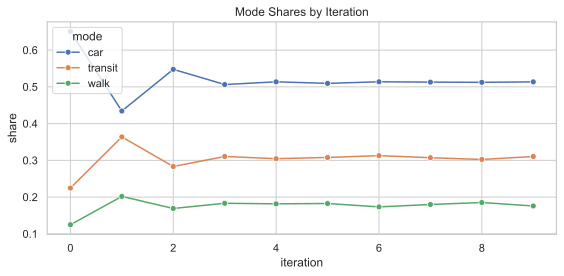

In [7]:
mode_shares_df = base_results["mode_shares_df"]

shares_long = mode_shares_df.melt(
    id_vars="iteration", var_name="mode", value_name="share"
)
plt.figure(figsize=(8, 4))
sns.lineplot(data=shares_long, x="iteration", y="share", hue="mode", marker="o")
plt.title("Mode Shares by Iteration")
plt.tight_layout()
plt.show()

## Artifact Lineage

The lineage tree shows how the final `skims` artifact traces back through the computational graph.
Reading the tree:

- Each **artifact** (like `skims`, `volumes`) shows its key and unique ID
- Below each artifact is the **run** that produced it, with the step name, run ID, and iteration number
- Indented below each run are its **input artifacts**, which recursively show their own producers

This forms a DAG (directed acyclic graph) where you can trace any output back to the original inputs.
With `max_depth=4`, we see four levels of this chain—in a 10-iteration model, the full lineage would
be much deeper.


In [8]:
final_skims = tracker.get_artifact("skims")
if final_skims:
    tracker.print_lineage(final_skims.id, max_depth=4)

Lineage
└── skims (zarr)
    └── ← traffic_simulation (iter 9)
        ├── skims (zarr)
        │   └── ← traffic_simulation (iter 8)
        │       ├── skims (zarr)
        │       │   └── ← traffic_simulation (iter 7)
        │       │       ├── skims (zarr)
        │       │       │   └── ← traffic_simulation (iter 6)
        │       │       │       ├── skims (zarr)
        │       │       │       └── volumes (parquet)
        │       │       └── volumes (parquet)
        │       │           └── ← assignment (iter 7)
        │       │               └── trips_with_modes (parquet)
        │       └── volumes (parquet)
        │           └── ← assignment (iter 8)
        │               └── trips_with_modes (parquet)
        │                   └── ← mode_choice (iter 8)
        │                       └── utilities (parquet)
        └── volumes (parquet)
            └── ← assignment (iter 9)
                └── trips_with_modes (parquet)
                    └── ← mode_choice (iter 9)
                        └── utilities (parquet)
                            └── ← calculate_utilities (iter 9)
                                ├── zones (parquet)
                                ├── skims (zarr)
                                └── trips (parquet)

## Incremental Computation Demo

We ran the baseline scenario for 10 iterations above. Now we extend to 15 iterations. Since the
extended run shares the same parameters for iterations 0-9, Consist should recognize those steps
have already been computed and skip them—only running iterations 10 through 14.


In [9]:
extended_config = replace(base_config, n_iterations=15)
extended_run_id = f"{SCENARIO_NAME}_{SESSION_ID}_extended"
extended_results = run_scenario(extended_config, extended_run_id)

In [10]:
# Quick cache-hit check for the extended run.
cached = [
    r for r in tracker.find_runs(parent_id=extended_run_id) if r.meta.get("cache_hit")
]
computed = [
    r
    for r in tracker.find_runs(parent_id=extended_run_id)
    if not r.meta.get("cache_hit")
]
print(f"Cache hits: {len(cached)}, Computed: {len(computed)}")

Cache hits: 61, Computed: 31


As expected, all steps from iterations 0-9 were retrieved from cache. The extended run only
computed the 5 new iterations, demonstrating how Consist enables incremental refinement of
iterative models.


## Cached runs and on-disk outputs

Because iterations 0-9 were cache hits, Consist does not re-run those steps or write their output
files under `examples/runs/travel_demand_demo/outputs/travel_demand_demo_demo_extended/`. The run
records and artifacts still exist in the database, and the original files still live in the earlier
run's output directory. If you want copies in a new location, you can materialize those cached
artifacts on demand.

See: [Caching and Hydration](../docs/caching-and-hydration.md) for more detail.


We start by listing the Parquet files that **were actually written** inside the extended run's output directory.
Cache hits do not re-materialize files, so this is the on-disk reality of the extended run.


In [11]:
from consist.core.materialize import materialize_artifacts

extended_outputs_dir = RUN_DIR / "outputs" / extended_run_id
extended_parquet = sorted(
    p.relative_to(extended_outputs_dir) for p in extended_outputs_dir.rglob("*.parquet")
)
extended_parquet[:10]

[PosixPath('assignment/iteration_10/volumes.parquet'),
 PosixPath('assignment/iteration_11/volumes.parquet'),
 PosixPath('assignment/iteration_12/volumes.parquet'),
 PosixPath('assignment/iteration_13/volumes.parquet'),
 PosixPath('assignment/iteration_14/volumes.parquet'),
 PosixPath('calculate_utilities/iteration_10/utilities.parquet'),
 PosixPath('calculate_utilities/iteration_11/utilities.parquet'),
 PosixPath('calculate_utilities/iteration_12/utilities.parquet'),
 PosixPath('calculate_utilities/iteration_13/utilities.parquet'),
 PosixPath('calculate_utilities/iteration_14/utilities.parquet')]

Next we pull a cached run from iteration 3 and show two things:
- which Parquet artifacts belong to that cached run, and
- whether those artifact paths already live under the **extended run** output directory.

This makes the cache behavior concrete: cached outputs exist in provenance even if the files are elsewhere.


In [12]:
cached_runs = tracker.find_runs(
    parent_id=extended_results["scenario_run_id"],
    model="mode_choice",
    iteration=3,
)
cached_run = next(run for run in cached_runs if run.meta.get("cache_hit"))
cached_outputs = tracker.find_artifacts(creator=cached_run)
cached_parquet = [
    art
    for art in cached_outputs
    if Path(tracker.resolve_uri(art.container_uri)).suffix == ".parquet"
]

print(f"Cached run: {cached_run.model_name} (iteration {cached_run.iteration})")
print(f"Output artifacts: {[art.key for art in cached_parquet]}")
print()
print("Where do cached artifacts live?")
for art in cached_parquet:
    path = Path(tracker.resolve_uri(art.container_uri))
    if str(path).startswith(str(extended_outputs_dir)):
        location = "extended run directory (copied)"
    else:
        location = "original run directory (reused)"
    print(f"  {art.key}: {location}")

Cached run: mode_choice (iteration 3)
Output artifacts: ['trips_with_modes']

Where do cached artifacts live?
  trips_with_modes: original run directory (reused)


Finally, we materialize one cached artifact into a fresh handoff directory and show the files created.
This is how you can share cached outputs without re-running the model.

> **Cache vs. disk**
> A cache hit means provenance links are reused; it does **not** guarantee new files appear in the current run directory.
> Use `materialize_artifacts(...)` when you need those cached outputs to exist on disk for handoff or inspection.


In [13]:
materialize_dir = RUN_DIR / "outputs" / f"{extended_run_id}_materialized"
art = cached_parquet[0]
dest = materialize_dir / f"{art.key}.parquet"
materialize_artifacts(tracker, [(art, dest)])
print(f"Materialized {art.key} to {dest.relative_to(RUN_DIR)}")

Materialized trips_with_modes to outputs/travel_demand_demo_demo_extended_materialized/trips_with_modes.parquet


## Querying Provenance

Now let's use Consist's query capabilities to explore runs and artifacts for a specific iteration.


In [14]:
# Runs for a specific iteration (e.g., iteration 5).
iteration_runs = tracker.find_runs(
    parent_id=SCENARIO_RUN_ID,
    status="completed",
    iteration=5,
)
iteration_run_df = pd.DataFrame(
    [
        {
            "model": run.model_name,
            "run_id": run.id,
            "iteration": run.iteration,
        }
        for run in iteration_runs
    ]
)
iteration_run_df

,model,run_id,iteration
0,traffic_simulation,travel_demand_demo_demo_traffic_simulation_5,5
1,assignment,travel_demand_demo_demo_assignment_5,5
2,mode_choice,travel_demand_demo_demo_mode_choice_5,5
3,calculate_utilities,travel_demand_demo_demo_utilities_5,5
4,trip_distribution,travel_demand_demo_demo_trip_distribution_5,5
5,logsums,travel_demand_demo_demo_logsums_5,5


We can find all the artifacts created during that iteration.


In [15]:
iter5_artifacts = {
    run.id: [artifact.key for artifact in tracker.find_artifacts(creator=run)]
    for run in iteration_runs
}
iter5_artifacts

{'travel_demand_demo_demo_traffic_simulation_5': ['skims'],
 'travel_demand_demo_demo_assignment_5': ['volumes'],
 'travel_demand_demo_demo_mode_choice_5': ['trips_with_modes'],
 'travel_demand_demo_demo_utilities_5': ['utilities'],
 'travel_demand_demo_demo_trip_distribution_5': ['trips'],
 'travel_demand_demo_demo_logsums_5': ['logsums']}

And we can check which outputs depend on a given input file. Let's see what we would need to invalidate if we updated the `zones` input file (just showing the first 10):

In [16]:
zone_consumers = []
for run in tracker.find_runs(parent_id=SCENARIO_RUN_ID, status="completed"):
    # get_run_inputs returns the run's input artifacts keyed by name.
    inputs = tracker.get_run_inputs(run.id)
    if "zones" in inputs:
        zone_consumers.append(run)
zone_consumer_df = pd.DataFrame(
    [
        {"model": run.model_name, "run_id": run.id, "iteration": run.iteration}
        for run in zone_consumers
    ]
)
zone_consumer_df.head(10)

,model,run_id,iteration
0,calculate_utilities,travel_demand_demo_demo_utilities_9,9
1,trip_distribution,travel_demand_demo_demo_trip_distribution_9,9
2,logsums,travel_demand_demo_demo_logsums_9,9
3,calculate_utilities,travel_demand_demo_demo_utilities_8,8
4,trip_distribution,travel_demand_demo_demo_trip_distribution_8,8
5,logsums,travel_demand_demo_demo_logsums_8,8
6,calculate_utilities,travel_demand_demo_demo_utilities_7,7
7,trip_distribution,travel_demand_demo_demo_trip_distribution_7,7
8,logsums,travel_demand_demo_demo_logsums_7,7
9,calculate_utilities,travel_demand_demo_demo_utilities_6,6


## Summary

This tutorial demonstrated three key provenance patterns:

1. **Deep chains**: Each iteration's outputs become the next iteration's inputs, creating
   traceable lineage dozens of steps deep.
2. **Incremental computation**: Running 15 iterations after already running 10 reused all
   prior work—only the new iterations executed.
3. **Impact analysis**: We can query which steps consume a given artifact to understand
   what would need to re-run if that artifact changed.

These patterns apply to any iterative workflow: MCMC sampling, neural network training checkpoints,
agent-based simulations, and economic equilibrium models.
